In [1]:
import random
import torch

from utils.Logger import showPlot
from utils.Timer import asMinutes, timeSince

%load_ext autoreload
from data.exampleJP_Data import Lang, prepareData
from model.rnn_model.encoderRNN import EncoderGRU, EncoderLSTM
from model.rnn_model.decoderRNN import (
    DecoderGRU, DecoderLSTM, 
    AttnDecoderGRU, AttnDecoderLSTM1, AttnDecoderLSTM2
)
from model.seq2seq_Model import (
    Seq2Seq_batch_ptModel, 
    Seq2SeqTranslate_ptTokenizer,
)
from baselineJP_ExpTrain import example_ExpTrain
from baseline_ExpEval import evaluate_batch_randomly
%autoreload


DATA_DIR = '../'

## load data

## setup Experiment

In [2]:
MAX_LENGTH = 40

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## setup Data

In [3]:
%load_ext autoreload
from data.ConstList_Data import Lang, prepareData
%autoreload

## Data
input_lang, output_lang, pairs = prepareData(
        'shuffled_elements', 'src_elements', DATA_DIR, 
        max_length=MAX_LENGTH, copy_num=10, reverse=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reading jsons...
['question', 'label', '/label', 'info', '/info', 'info', '/info', 'question', 'label', '/label', 'instruction', 'formula', '/formula', 'formula', '/formula', 'formula', '/formula', 'formula', 'ansColumn', 'ansColumn', 'ansColumn', 'ansColumn', '/formula', 'formula', 'ansColumn', 'ansColumn', '/formula', 'formula', 'ansColumn', 'ansColumn', '/formula', '/instruction', 'page_num', '/page_num']
710 2 105 105
ansColumn ansColumn /formula /formula /formula formula /formula formula ansColumn formula ansColumn
Read 710 sentence pairs
Trimmed to 710 sentence pairs
Counting words...
Counted words:
shuffled_elements 27
src_elements 27


In [4]:
print(random.choice(pairs))
print(input_lang.n_words, output_lang.n_words)

('choices ansColumn ref /ref /formula ansColumn /instruction /ref ref /ref ref ansColumn ansColumn ref /ref', 'ansColumn ansColumn ansColumn ansColumn /formula ref /ref ref /ref ref /ref ref /ref /instruction choices')
27 27


In [5]:
# train / test split
from sklearn.model_selection import train_test_split
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2)

## setup Model

In [6]:
## Model
tokenizer = Seq2SeqTranslate_ptTokenizer(
                    input_lang, output_lang, device)

### test

In [7]:
batch_size = 10
emb_size = 8
hid_size = 12

test_encoder = EncoderLSTM(input_lang.n_words, emb_size, hid_size)
test_decoder1 = AttnDecoderLSTM1(
                    emb_size, hid_size, output_lang.n_words,
                    device, max_length=MAX_LENGTH)
seq2seq_test_model = Seq2Seq_batch_ptModel(
                    tokenizer, device,
                    dropout_p=0.1, max_length=MAX_LENGTH)
seq2seq_test_model.set_models(test_encoder, test_decoder1)
seq2seq_test_model.exec_test(train_pairs, batch_size=batch_size)


[Info] input_batch.shape, input_lens.shape
     =  torch.Size([16, 10]) torch.Size([10])
[Info] enc_outputs.shape, hidden_h.shape, hidden_c.shape
     =  torch.Size([16, 10, 24]) torch.Size([1, 10, 12]) torch.Size([1, 10, 12])
[Info] hidden[0].shape, hidden[1].shape
     =  torch.Size([10, 12]) torch.Size([10, 12])
[Info] dec_outputs.shape, hidden[0].shape, hidden[1].shape, attn_weights.shape
     =  torch.Size([10, 27]) torch.Size([10, 12]) torch.Size([10, 12]) torch.Size([10, 20])
[Info] loss.item()
     =  3.250727891921997


In [8]:
attn_size = 9

test_decoder2 = AttnDecoderLSTM2(
                    emb_size, hid_size, attn_size, 
                    output_lang.n_words, device).to(device)
seq2seq_test_model.set_models(test_encoder, test_decoder2)
seq2seq_test_model.exec_test(train_pairs, batch_size=batch_size)

[Info] input_batch.shape, input_lens.shape
     =  torch.Size([17, 10]) torch.Size([10])
[Info] enc_outputs.shape, hidden_h.shape, hidden_c.shape
     =  torch.Size([17, 10, 24]) torch.Size([1, 10, 12]) torch.Size([1, 10, 12])
[Info] hidden[0].shape, hidden[1].shape
     =  torch.Size([10, 12]) torch.Size([10, 12])
[Info] dec_outputs.shape, hidden[0].shape, hidden[1].shape, attn_weights.shape
     =  torch.Size([10, 27]) torch.Size([10, 12]) torch.Size([10, 12]) torch.Size([10, 17])
[Info] loss.item()
     =  3.340771436691284


## setup Model

In [9]:
# %load_ext autoreload
# from model.rnn_model.decoderRNN import (
#     DecoderGRU, DecoderLSTM, 
#     AttnDecoderGRU, AttnDecoderLSTM1, AttnDecoderLSTM2
# )
# from model.seq2seq_Model import (
#     Seq2Seq_batch_ptModel, 
#     Seq2SeqTranslate_ptTokenizer,
# )
# from baselineJP_ExpTrain import example_ExpTrain
# from baselineJP_ExpTrain import example_ExpTrain
# %autoreload

load_model_dir = '_best_weight' if torch.cuda.is_available() else "_best_weight_CPU"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
emb_size = 1024
hidden_size = 1024

def build_encoder():
    encoder = EncoderLSTM(input_lang.n_words, emb_size, hidden_size)
    # encoder.load_weights(
    #             load_m_dir=f'_logs/{load_model_dir}', 
    #             load_m_file_name='encoder.pth')
    return encoder

In [11]:
# Experiment
exp_train = example_ExpTrain(train_pairs, test_pairs)

## exec

In [12]:
# encoder
encoder = build_encoder()
# decoder
decoder1 = AttnDecoderLSTM1(
                emb_size, hidden_size, output_lang.n_words, device)
# decoder1.load_weights(
#             load_m_dir=f'_logs/{load_model_dir}', 
#             load_m_file_name='decoder_LSTM1.pth')

# seq2seq model
seq2seq_lstm1_model = Seq2Seq_batch_ptModel(
                        tokenizer, device,
                        dropout_p=0.1, max_length=MAX_LENGTH,
                        save_m_dir='_logs', 
                        save_m_file_names=(
                            'encoder.pth', 'decoder_LSTM1.pth'))
seq2seq_lstm1_model.set_models(encoder, decoder1)

## exec
exp_train.exec(seq2seq_lstm1_model, 
                # epochs=3, batch_size=100, 
                epochs=100, batch_size=50, 
                teacher_forcing=0.9, early_stopping=6)

  0%|          | 0/20 [00:00<?, ?it/s]/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps

0.0

In [ ]:
evaluate_batch_randomly(seq2seq_lstm1_model, test_pairs, n=10)

In [13]:
# encoder
encoder = build_encoder()
# decoder
attn_size = 1024
decoder2 = AttnDecoderLSTM2(
                emb_size, hidden_size, attn_size, 
                output_lang.n_words, device)
# decoder2.load_weights(
#             load_m_dir=f'_logs/{load_model_dir}', 
#             load_m_file_name='decoder_LSTM2.pth')

# seq2seq model
seq2seq_lstm2_model = Seq2Seq_batch_ptModel(
                        tokenizer, device,
                        dropout_p=0.1, max_length=MAX_LENGTH,
                        save_m_dir='_logs', 
                        save_m_file_names=(
                            'encoder.pth', 'decoder_LSTM2.pth'))
seq2seq_lstm2_model.set_models(encoder, decoder2)

## exec
exp_train.exec(seq2seq_lstm2_model, 
                # epochs=3, batch_size=100, 
                epochs=100, batch_size=50, 
                teacher_forcing=0.9, early_stopping=6)

100%|██████████| 20/20 [13:02<00:00, 39.12s/it]


0.0

> instruction /info /label info question formula info formula label /info /formula
= question label /label info /info info /info instruction formula /formula formula
< question label /label info /info info /info instruction formula /formula formula /formula formula /formula formula <EOS>
bleu: 0.7012055133086459



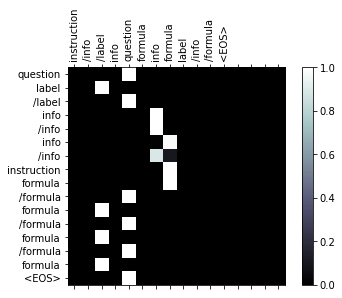

> formula /formula ansColumn formula formula formula /formula formula ansColumn instruction ansColumn ansColumn /formula /formula ansColumn
= instruction formula /formula formula /formula formula /formula formula ansColumn ansColumn /formula formula ansColumn ansColumn ansColumn
< /formula formula /formula formula ansColumn /formula formula ansColumn ansColumn /formula formula ansColumn ansColumn /formula formula ansColumn ansColumn /formula
bleu: 0.6233473783356551



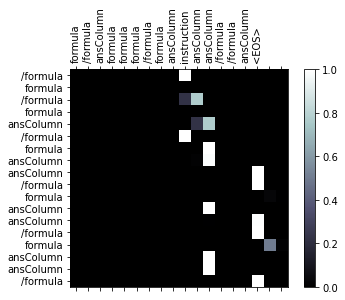

> instruction formula /formula /info /info label info question info formula formula formula /formula /label /formula
= question label /label info /info info /info instruction formula /formula formula /formula formula /formula formula
< question label /label info /info info /info instruction formula /formula formula /formula formula /formula formula /formula formula <EOS>
bleu: 0.8702397637697912



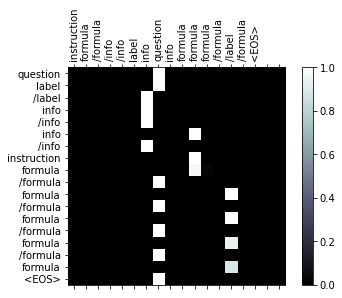

> /instruction choice choice choices /cNum /cNum /choice cNum cNum
= /instruction choices choice cNum /cNum /choice choice cNum /cNum
< /instruction choices choice cNum /cNum /choice choice cNum /cNum formula /formula /choice choice cNum /cNum formula /formula /choice
bleu: 0.479676449968321



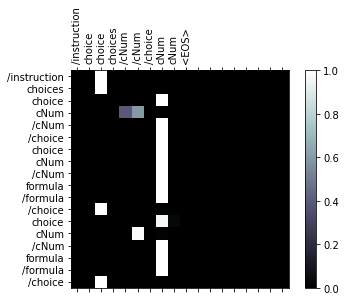

> question formula /info formula info formula /formula formula instruction /formula /formula info label /label /formula /info
= question label /label info /info info /info instruction formula /formula formula /formula formula /formula formula /formula
< question label /label info /info info /info instruction formula /formula formula /formula formula /formula formula /formula formula /formula
bleu: 0.9351334836242398



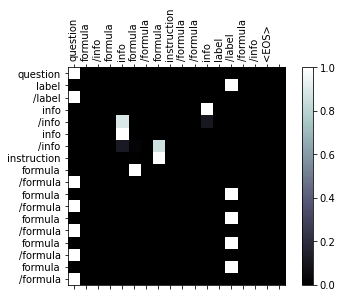

> /cNum /choice /cNum choice formula cNum formula choice cNum /choice /formula /cNum choice cNum /formula
= choice cNum /cNum formula /formula /choice choice cNum /cNum formula /formula /choice choice cNum /cNum
< /choice choice cNum /cNum formula /formula /choice choice cNum /cNum formula /formula /choice choice cNum /cNum formula /formula
bleu: 0.8702397637697912



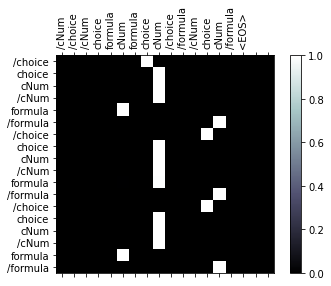

> label /instruction /question /page_num instruction question /instruction page_num /label /formula
= /formula /instruction question label /label instruction /instruction /question page_num /page_num
< question label /label instruction /instruction /question page_num /page_num <EOS>
bleu: 0.7788007830714049



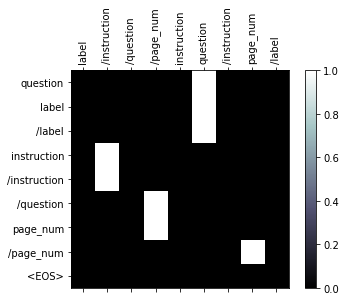

> /formula ansColumn formula formula ansColumn ansColumn ansColumn /formula formula /formula /formula ansColumn ansColumn formula
= /formula formula /formula formula ansColumn ansColumn ansColumn ansColumn ansColumn ansColumn /formula formula /formula formula
< /formula formula ansColumn ansColumn /formula formula ansColumn ansColumn /formula formula ansColumn /formula formula ansColumn ansColumn /formula formula ansColumn
bleu: 0.364475284252601



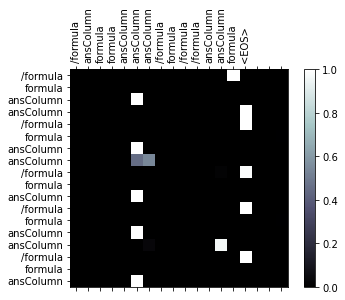

> formula /formula ansColumn formula formula formula /formula formula ansColumn instruction ansColumn ansColumn /formula /formula ansColumn
= instruction formula /formula formula /formula formula /formula formula ansColumn ansColumn /formula formula ansColumn ansColumn ansColumn
< /formula formula /formula formula ansColumn ansColumn /formula formula ansColumn ansColumn /formula formula ansColumn /formula formula ansColumn ansColumn /formula
bleu: 0.6233473783356551



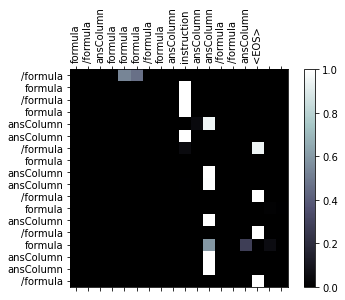

> formula formula formula /formula formula formula /formula /formula formula /formula formula /formula /formula /formula
= /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula
< /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula /formula formula
bleu: 0.805312203079627



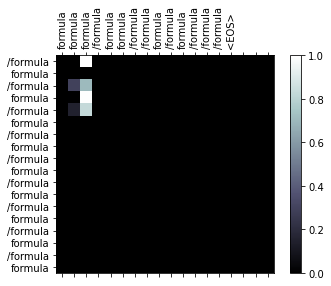

[0.7012055133086459,
 0.6233473783356551,
 0.8702397637697912,
 0.479676449968321,
 0.9351334836242398,
 0.8702397637697912,
 0.7788007830714049,
 0.364475284252601,
 0.6233473783356551,
 0.805312203079627]

In [14]:
evaluate_batch_randomly(seq2seq_lstm2_model, test_pairs, n=10)